In [2]:
!pip install google-cloud-bigquery pandas matplotlib seaborn --quiet

In [3]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
client = bigquery.Client()

query = """
SELECT 
  date,
  subregion1_name,
  cumulative_confirmed,
  cumulative_deceased
FROM 
  bigquery-public-data.covid19_open_data.covid19_open_data
WHERE 
  country_name = 'Brazil'
  AND subregion1_name IS NOT NULL
  AND date BETWEEN '2020-04-01' AND '2023-12-01'
ORDER BY date
LIMIT 1000
"""

df = client.query(query).to_dataframe()
df.head()

,date,subregion1_name,cumulative_confirmed,cumulative_deceased
0,2020-04-01,Paraíba,0,0
1,2020-04-01,Bahia,0,0
2,2020-04-01,Minas Gerais,1,0
3,2020-04-01,Rio de Janeiro,1,0
4,2020-04-01,Pernambuco,0,0


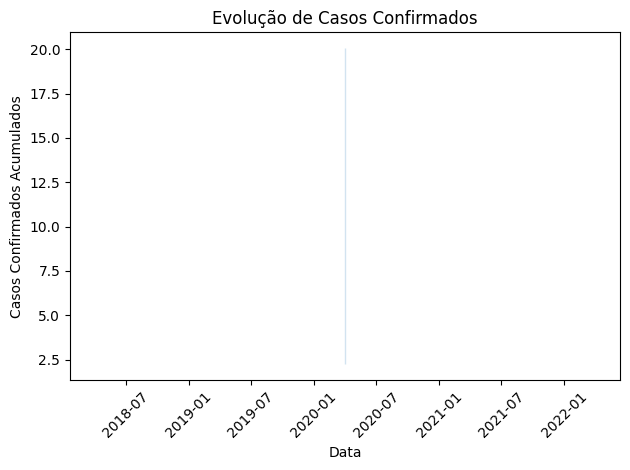

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico de linha para casos confirmados
sns.lineplot(data=df, x='date', y='cumulative_confirmed')
plt.xticks(rotation=45)
plt.title('Evolução de Casos Confirmados')
plt.xlabel('Data')
plt.ylabel('Casos Confirmados Acumulados')
plt.tight_layout()
plt.show()

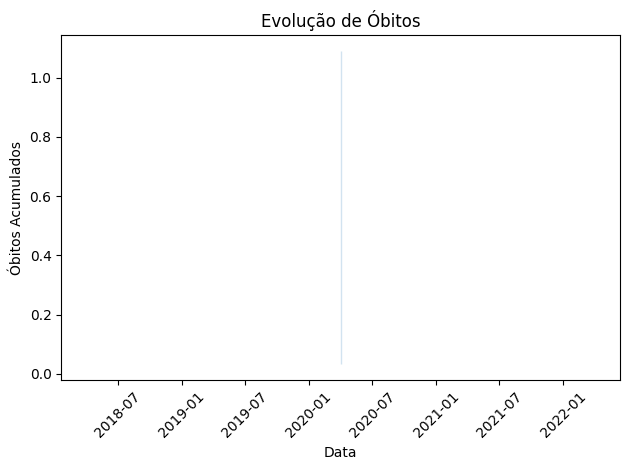

In [39]:
# Gráfico de linha para óbitos
sns.lineplot(data=df, x='date', y='cumulative_deceased')
plt.xticks(rotation=45)
plt.title('Evolução de Óbitos')
plt.xlabel('Data')
plt.ylabel('Óbitos Acumulados')
plt.tight_layout()
plt.show()

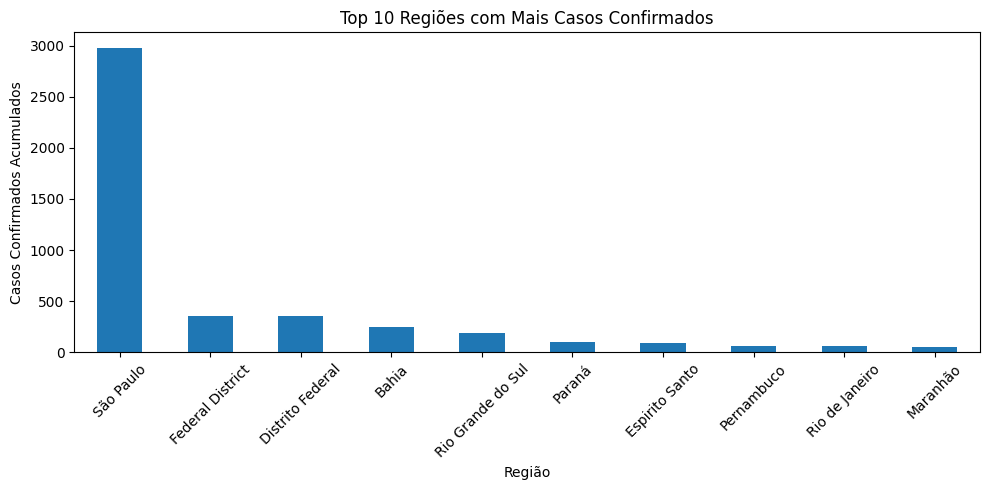

In [40]:
# Agrupar por região e somar os casos confirmados
top_regioes = df.groupby('subregion1_name')['cumulative_confirmed'].max().sort_values(ascending=False).head(10)

# Gráfico de barras
top_regioes.plot(kind='bar', figsize=(10,5), title='Top 10 Regiões com Mais Casos Confirmados')
plt.xlabel('Região')
plt.ylabel('Casos Confirmados Acumulados')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

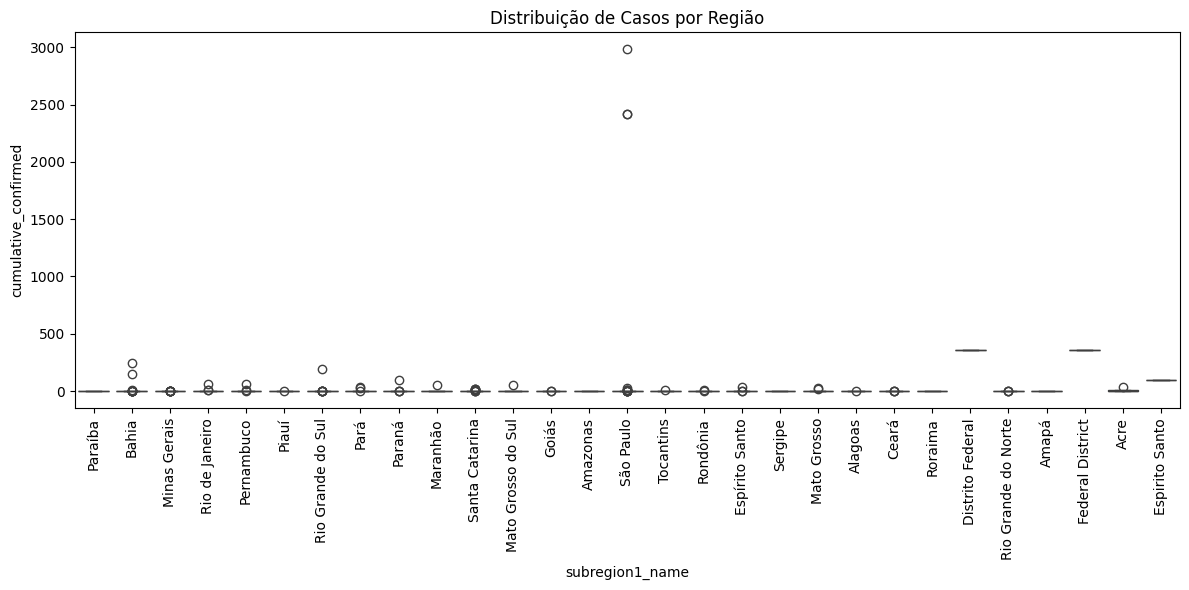

In [41]:
# Boxplot dos casos por região
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='subregion1_name', y='cumulative_confirmed')
plt.title('Distribuição de Casos por Região')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

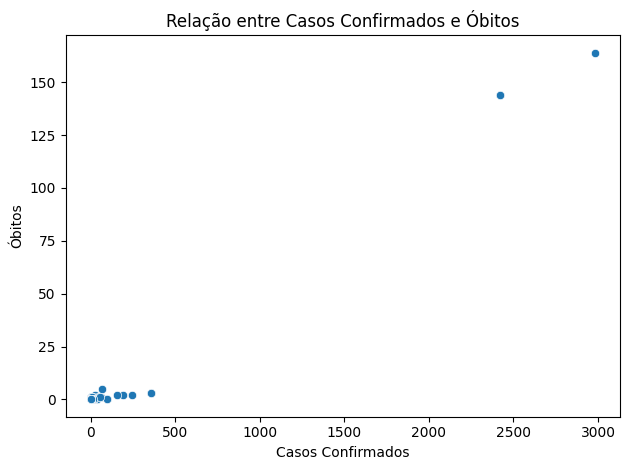

In [42]:
# Scatter plot entre casos e óbitos
sns.scatterplot(data=df, x='cumulative_confirmed', y='cumulative_deceased')
plt.title('Relação entre Casos Confirmados e Óbitos')
plt.xlabel('Casos Confirmados')
plt.ylabel('Óbitos')
plt.tight_layout()
plt.show()

In [43]:
df.isnull().sum()

date                    0
subregion1_name         0
cumulative_confirmed    3
cumulative_deceased     3
dtype: int64

In [44]:
df['cumulative_confirmed'] = df['cumulative_confirmed'].fillna(0)
df['cumulative_deceased'] = df['cumulative_deceased'].fillna(0)

In [45]:
# Removendo espaços extras no nome das colunas (se existirem)
df.columns = df.columns.str.strip()

In [46]:
# Preenchendo valores ausentes com 0
df['cumulative_confirmed'] = df['cumulative_confirmed'].fillna(0)
df['cumulative_deceased'] = df['cumulative_deceased'].fillna(0)

In [47]:
# Criando novas colunas com dados diários
df['new_confirmed'] = df.groupby('subregion1_name')['cumulative_confirmed'].diff().fillna(0)
df['new_deceased'] = df.groupby('subregion1_name')['cumulative_deceased'].diff().fillna(0)


In [48]:
# Garantindo que valores negativos (por erro de registro) sejam zerados
df['new_confirmed'] = df['new_confirmed'].apply(lambda x: x if x >= 0 else 0)
df['new_deceased'] = df['new_deceased'].apply(lambda x: x if x >= 0 else 0)

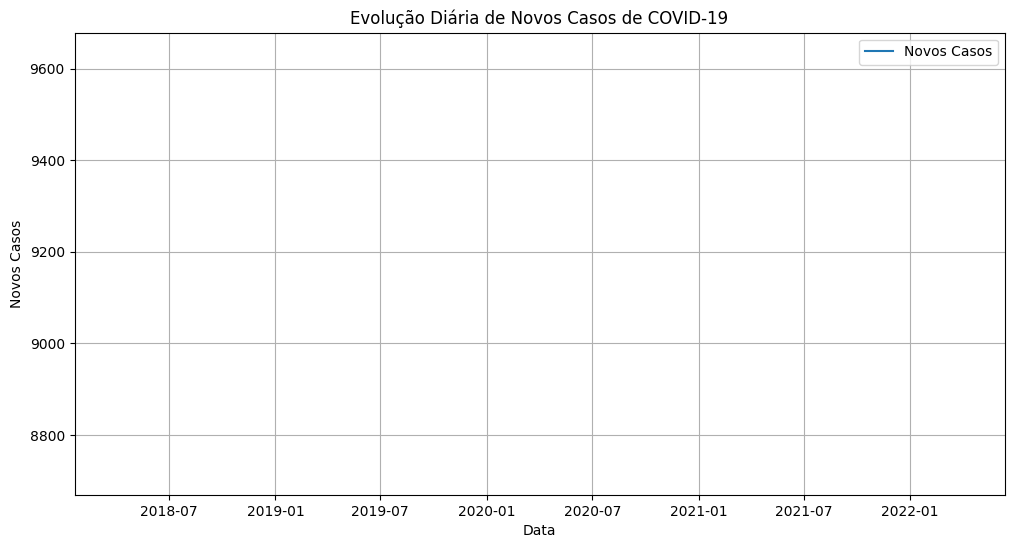

In [49]:
# Evolução de casos diários em todo o país
df_grouped = df.groupby('date')['new_confirmed'].sum().reset_index()

plt.figure(figsize=(12,6))
plt.plot(df_grouped['date'], df_grouped['new_confirmed'], label='Novos Casos')
plt.title('Evolução Diária de Novos Casos de COVID-19')
plt.xlabel('Data')
plt.ylabel('Novos Casos')
plt.legend()
plt.grid(True)
plt.show()

/var/tmp/ipykernel_3906/2862419358.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_regioes, x='cumulative_confirmed', y='subregion1_name', palette='Reds_r')


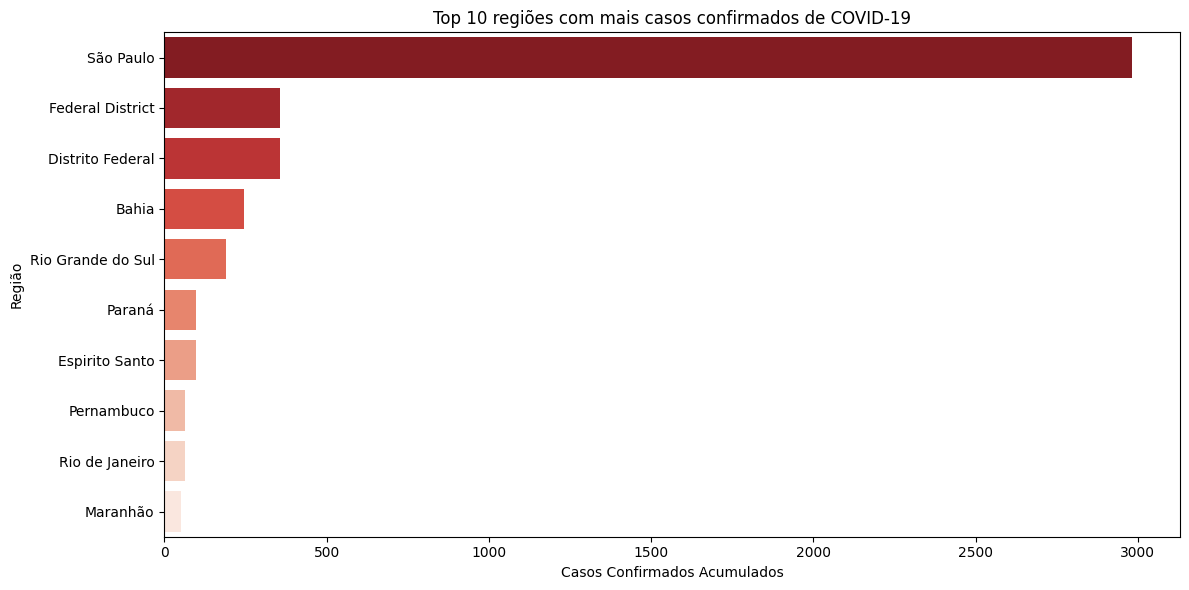

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupando por região e somando os casos confirmados
df_regioes = df.groupby('subregion1_name')['cumulative_confirmed'].max().reset_index()

# Ordenando do maior para o menor
df_regioes = df_regioes.sort_values(by='cumulative_confirmed', ascending=False).head(10)

# Plotando
plt.figure(figsize=(12,6))
sns.barplot(data=df_regioes, x='cumulative_confirmed', y='subregion1_name', palette='Reds_r')
plt.title('Top 10 regiões com mais casos confirmados de COVID-19')
plt.xlabel('Casos Confirmados Acumulados')
plt.ylabel('Região')
plt.tight_layout()
plt.show()

In [51]:
df['media_movel'] = df['new_confirmed'].rolling(7).mean()

<Axes: xlabel='date', ylabel='media_movel'>

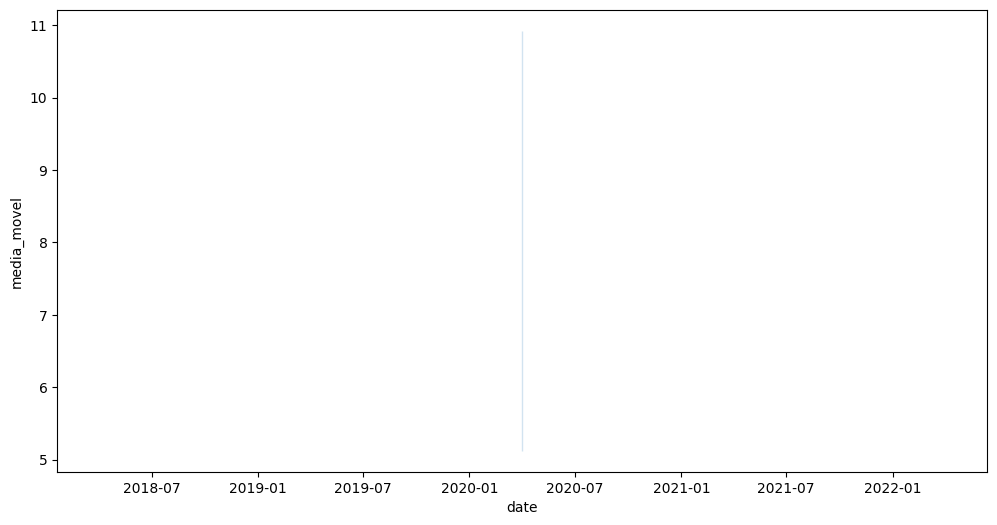

In [52]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='media_movel')

In [53]:
df.to_csv('covid_final.csv', index=False)

In [57]:
from google.cloud import bigquery
import pandas as pd

# 1. Correta leitura do arquivo CSV
# Certifique-se que o arquivo 'covid_final.csv' está no mesmo diretório do notebook
# Ou especifique o caminho completo
df = pd.read_csv('covid_final.csv')  # Correto: pd.read_csv() em vez de pd.DataFrame()

# 2. Verifique os dados
print(df.head())  # Visualize as primeiras linhas para confirmar que carregou corretamente

# 3. Exportar para BigQuery (com nomes corrigidos)
# O destination_table deve seguir formato: dataset.tabela (não pode ter .ipynb)
df.to_gbq(
    destination_table='covid_dataset.covid_data',  # Nome mais adequado
    project_id='projeto-final-ebac',
    if_exists='replace'  # Pode ser 'append' para adicionar dados
)

print("Dados exportados com sucesso para o BigQuery!")

         date subregion1_name  cumulative_confirmed  cumulative_deceased  \
0  2020-04-01         Paraíba                     0                    0   
1  2020-04-01           Bahia                     0                    0   
2  2020-04-01    Minas Gerais                     1                    0   
3  2020-04-01  Rio de Janeiro                     1                    0   
4  2020-04-01      Pernambuco                     0                    0   

   new_confirmed  new_deceased  media_movel  
0              0             0          NaN  
1              0             0          NaN  
2              0             0          NaN  
3              0             0          NaN  
4              0             0          NaN  


/var/tmp/ipykernel_3906/2323287104.py:14: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 8289.14it/s]

Dados exportados com sucesso para o BigQuery!


In [58]:
from google.cloud import bigquery

client = bigquery.Client(project='projeto-final-ebac')

# Consulta de verificação
query = """
SELECT *
FROM projeto-final-ebac.covid_dataset.covid_data
LIMIT 5
"""

results = client.query(query).to_dataframe()
print(results)

         date subregion1_name  cumulative_confirmed  cumulative_deceased  \
0  2020-04-01           Bahia                     1                    0   
1  2020-04-01           Bahia                     0                    0   
2  2020-04-01           Bahia                     0                    0   
3  2020-04-01  Espírito Santo                    35                    0   
4  2020-04-01  Espírito Santo                     0                    0   

   new_confirmed  new_deceased  media_movel  
0              1             0     9.285714  
1              0             0     7.285714  
2              0             0     3.857143  
3             35             0     6.285714  
4              0             0   345.428571  
